## 403 Final 
### Baishi Pu 1004916184

## Introduction
In this lab, we will look at materials modulus data in Ni-Mn-Al alloy system. 
- In Part I, LASSO will be used as a linear model to perform a regression task. Its hyperparameters will be tuned by cross-validation, and the tuned model will be trained on the whole dataset, and make prediction on the whole data set.
- In Part II, a gaussian process regressor will be used to perform linear regression on a larger but similar set of data. The goal is to find the composition with the largest material modulus, using as little observation of ground truth as possible. Three methods (random observe, exploitation, Upper Confidence Bound) were used, and it was found that exploitation and Upper Confidence Bound are similar in terms of performance, consistently outperforming random search.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

## Part I: LINEAR MODEL REGRESSION
### 1. Read data, perform data cleaning, and drop correlated features
- Deliver: X, y

In [156]:
# take a look
dff = pd.read_csv('dataset for Cross Validation and Hyperparameter Tuning.csv') ###
dff = dff.dropna()

# drop the column if the entire column is the same value
dff = dff.loc[:, dff.apply(pd.Series.nunique) != 1]

# drop columns containing non-numerical values
numeric_cols = dff.select_dtypes(include=['int64', 'float64']).columns
dff = dff[numeric_cols]
dff.head()

Ni at.%   Mn at.%   Al at.%  modulus (arb. Units)  \
0  0.244211  0.551914  0.203875               217.191   
1  0.435148  0.495154  0.069699               211.719   
2  0.133354  0.407527  0.459119               207.905   
3  0.365033  0.192957  0.442010               207.606   
4  0.178796  0.442782  0.378422               209.144   

   MagpieData minimum Number  MagpieData maximum Number  \
0                   -1.26057                  -0.527200   
1                   -0.48688                   1.718950   
2                   -3.02645                  -1.009930   
3                    3.30867                   3.798520   
4                    1.05913                  -0.052029   

   MagpieData range Number  MagpieData mean Number  MagpieData avg_dev Number  \
0                -1.328770                0.567618                  -1.291290   
1                 1.736830               -1.775920                   1.085450   
2                -0.406078               -3.337590                  -0.354072   
3                 1.762440                3.382100                   3.002900   
4                 2.368820                0.639958                   0.035809   

   MagpieData mode Number  ...  MagpieData range GSmagmom  \
0               -0.831746  ...                   0.768405   
1                0.527052  ...                   0.210875   
2               -1.545700  ...                   2.144210   
3                2.433820  ...                   1.339990   
4                0.542045  ...                   2.832570   

   MagpieData mean GSmagmom  MagpieData avg_dev GSmagmom  \
0                 -0.281714                    -1.455880   
1                  1.954310                     2.120660   
2                  2.413050                    -0.207646   
3                  0.155082                     0.366285   
4                  0.716758                    -0.102232   

   MagpieData mode GSmagmom  MagpieData minimum SpaceGroupNumber  \
0                 -0.304815                             1.457910   
1                  1.482310                             0.917220   
2                  3.166110                             0.851799   
3                  1.321890                             0.931454   
4                  0.858713                             1.212380   

   MagpieData maximum SpaceGroupNumber  MagpieData range SpaceGroupNumber  \
0                             0.244211                           0.551914   
1                             0.435148                           0.495154   
2                             0.133354                           0.407527   
3                             0.365033                           0.192957   
4                             0.178796                           0.442782   

   MagpieData range Electronegativity  MagpieData mode CovalentRadius  \
0                            0.815564                        0.637034   
1                            0.932675                        0.662864   
2                            0.631840                        0.628213   
3                            0.642743                        0.604859   
4                            0.684941                        0.609284   

   MagpieData mean MeltingT  
0                  0.052066  
1                 -0.603239  
2                 -0.092669  
3                  1.100760  
4                 -0.034487  

[5 rows x 136 columns]

132  features before correlation analysis
THRESHOLD:  0.75


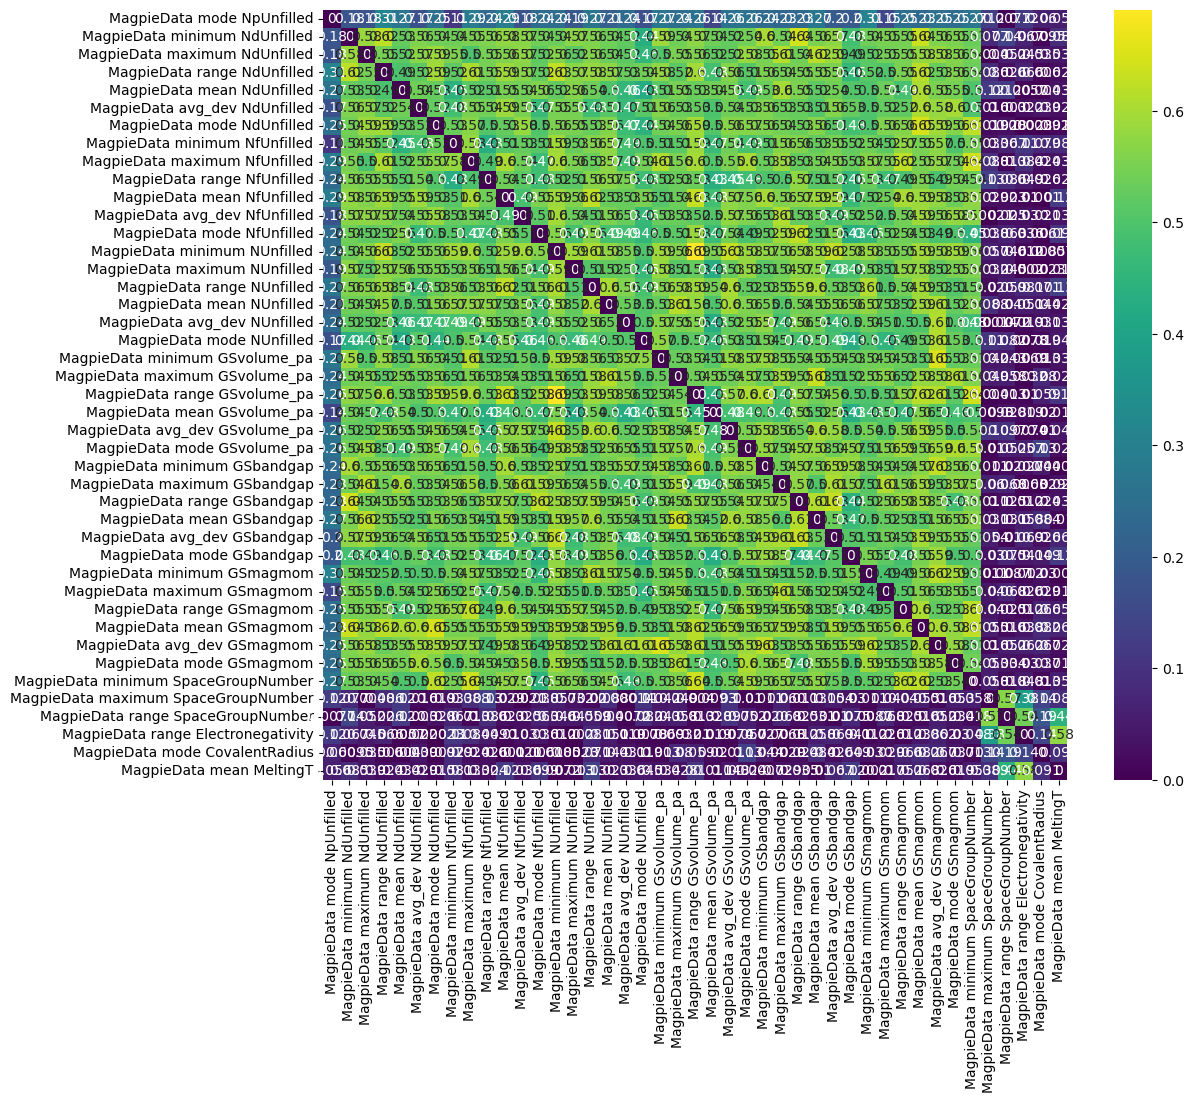

43  features after correlation analysis


In [157]:
'''
From (the numerical-only) dff we create a few new variables: 
    - features_all, all features as providede, used only for correlation analysis
    -  y, the target value'''

# make a new df with only the numerical features
features_all = dff.iloc[:, 4:] ###
y = dff['modulus (arb. Units)'].to_numpy() ###

'''
After dropping correlated ones:
    - features, the remaining features used for the model
    - X, spun off from features'''

print(len(features_all.columns), ' features before correlation analysis')

# drop correlated features
from CustomFunctions import ranked_drop
features = ranked_drop(features_all, 0.75, plot=True)
X = features.to_numpy()

print(len(features.columns), ' features after correlation analysis')
# features.head()

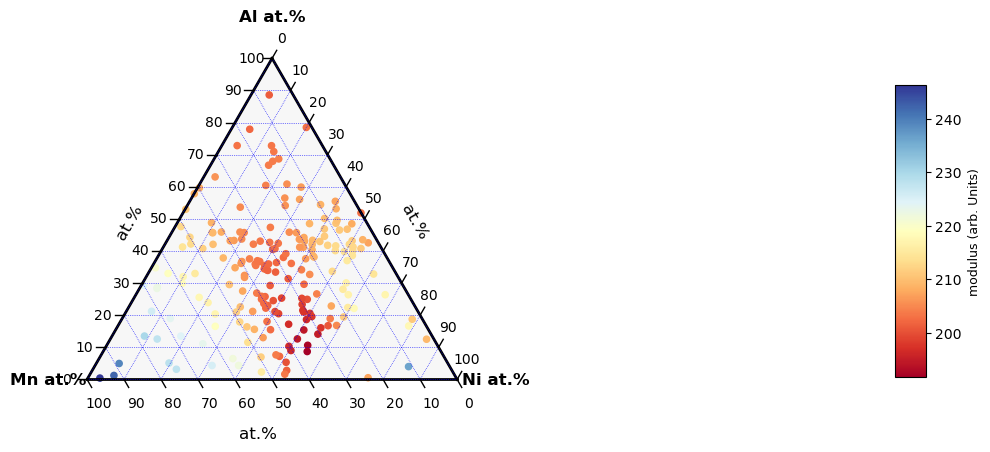

In [158]:
# plot the ternary diagram
from CustomFunctions import df_plot_ternary
fig, axs = plt.subplots(1, 2, figsize = (9, 4))
fig.tight_layout(pad = 0)

df_plot_ternary(dff, y, ax = axs[0], label = 'modulus (arb. Units)', cmap = plt.cm.RdYlBu)

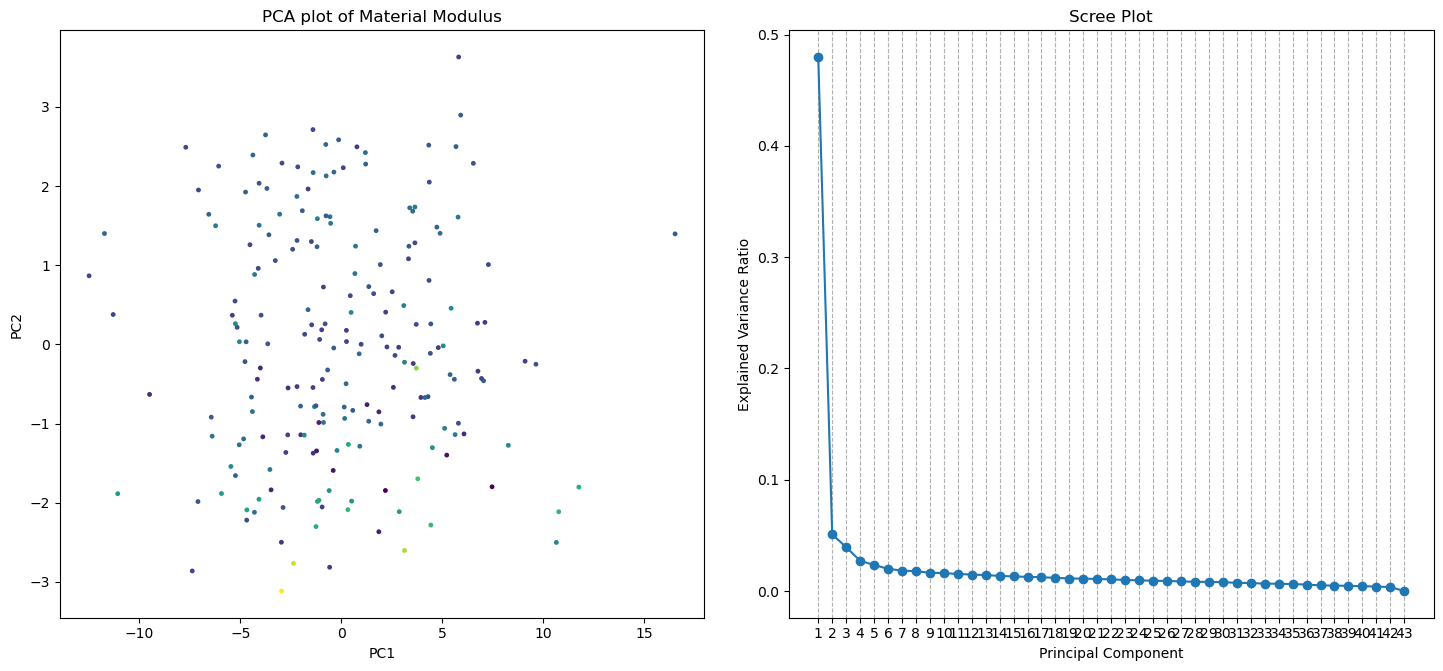

In [159]:
from CustomFunctions import pca_plot
# plot PCA, colored by the target value (modulus)
X_pca = pca_plot(features.to_numpy(), n_comp = 5, color_label=y, title = 'PCA plot of Material Modulus', return_scree=True, alpha = 1)

- Consistent with understanding is that the target value is mostlu continuous over the ternary phase diagram, with Al having small modulus and Mn and Ni having larger modulus.
    - From the PCA and scree plot, the data is rather flat in the paramter space, where 2 components is enough to explain more than half of the variance. PC2 dominates the distribution of modulus - where PC2 is small, the modulus is high.

- What is counter-intuitive is that pure element has higher module, and center equal-composition region having the lowest. Ususally, alloying different elements makes higher modulus as interstitial occupancy/substitution hinders dislocation movement

- Blue data point near Ni seems suspicious, as the two others close to it are having very different modulus.

### 2. Gridsearch the best parameters

In [48]:
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import Lasso

Justify parameter choice:

- Lasso does not have many parameters. Alpha is the most important one, and we also want to look at tolerance "tol" as this affects computation time, we want to have the largest tol (without compromising model performance)

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.477e+02, tolerance: 1.154e+01
  model = cd_fast.enet_coordinate_descent(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.637e+02, tolerance: 1.209e+00
  model = cd_fast.enet_coordinate_descent(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Text(50.7222222222222, 0.5, 'lasso__alpha')

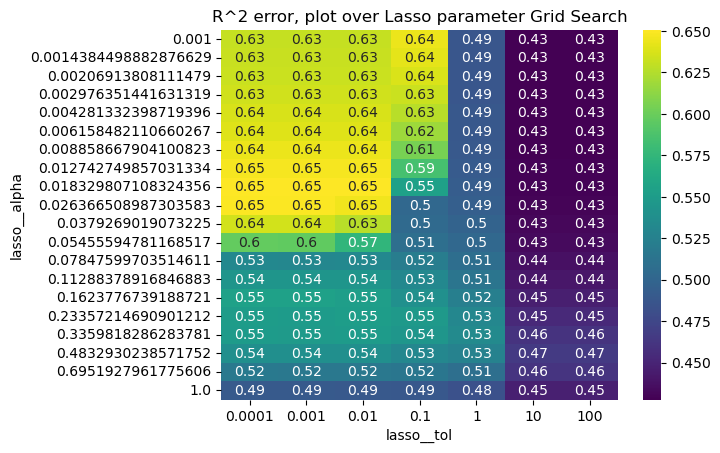

In [49]:
# Regression
params = {'lasso__alpha': np.logspace(-3, 0, 20),
          'lasso__tol': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
          }

scaler = StandardScaler()
# X_std = scaler_train.transform(X)

KF = KFold(n_splits=5, shuffle=True, random_state=0)
# lasso = Lasso(random_state=0)

pipeline = Pipeline(steps=[("scaler", scaler), ("lasso", Lasso())])

GSCV = GridSearchCV(pipeline, param_grid=params, scoring='r2', cv=KF, n_jobs=-1).fit(X, y)

# print('Optimal Parameteres: ', GSCV.best_params_)
Z = GSCV.cv_results_['mean_test_score'].reshape(
    len(params['lasso__alpha']), len(params['lasso__tol']))
# '''INSTEAD OF CONTOUR PLOT, we plot he heatmap as it allows better visualization of 
# the numeric score of each combination'''
sb.heatmap(Z, cmap='viridis', annot=True, xticklabels=params['lasso__tol'], 
           yticklabels=params['lasso__alpha'])
plt.title('R^2 error, plot over Lasso parameter Grid Search')
plt.xlabel('lasso__tol')
plt.ylabel('lasso__alpha')

/var/folders/zn/k77176sn251cms9l_n4s7zb80000gn/T/ipykernel_68378/639217122.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


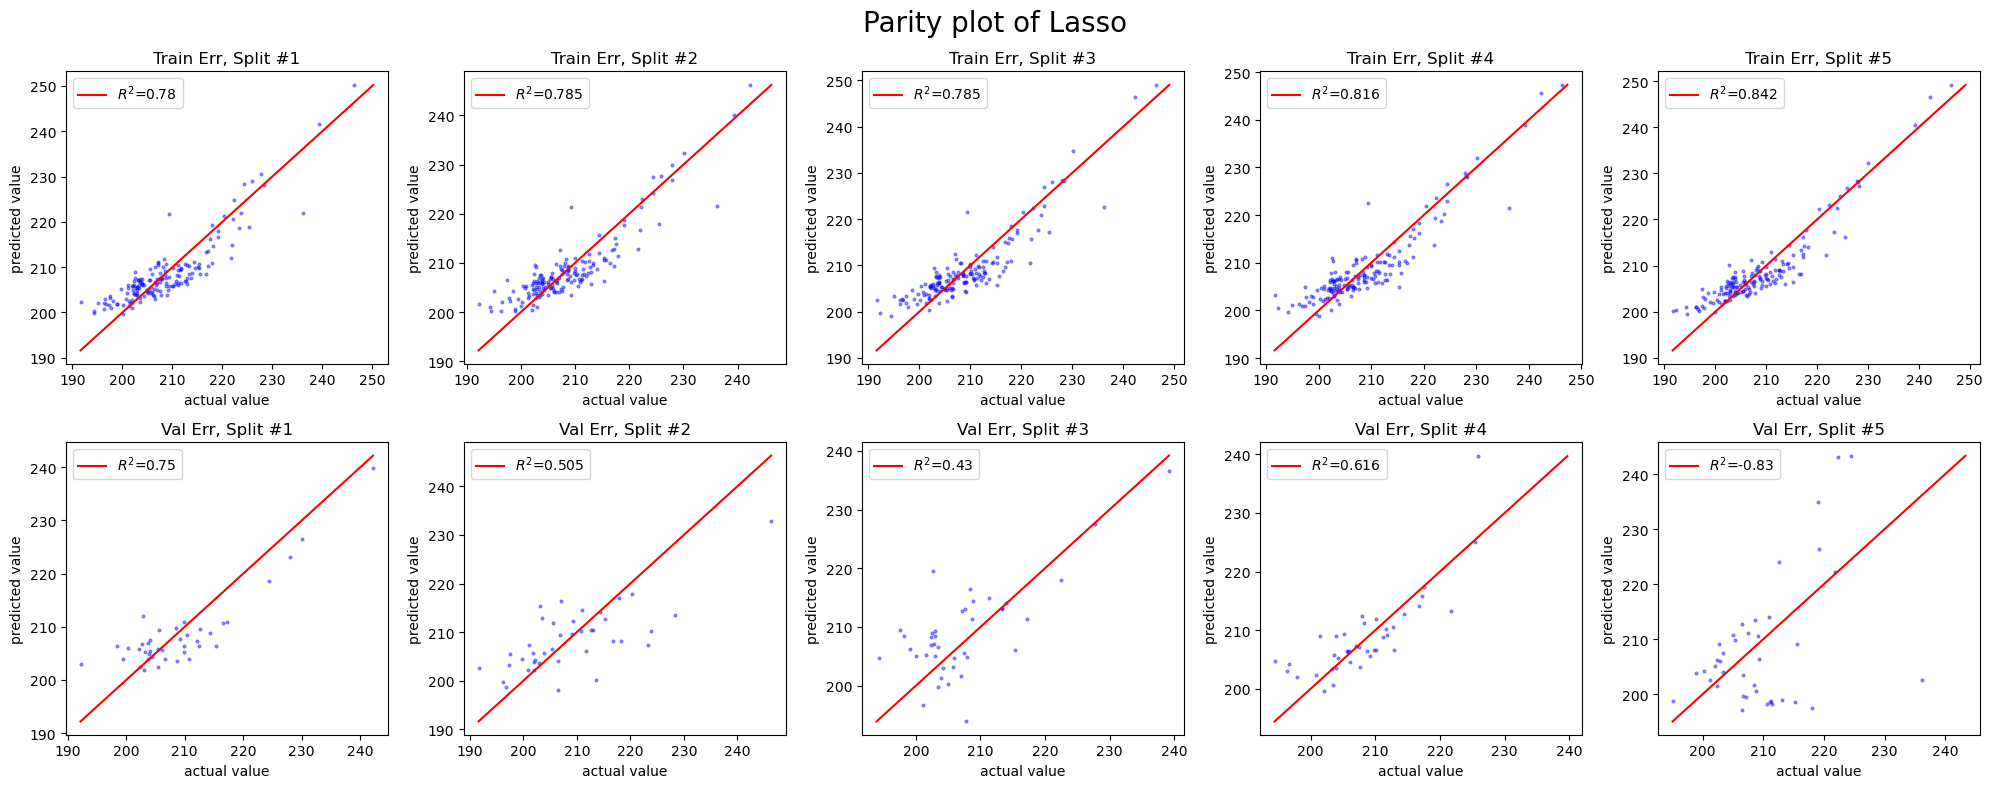

In [166]:
# from here we will use tol = 0.01 and alpha = 0.018, and report the cross validation performance
# below lasso is the optimal model (parameters tuned), but not trained
from CustomFunctions import CrossValidate

lasso = Lasso(tol = 0.01, alpha = 0.018, random_state=0)
# inside the function X is standardized
CrossValidate(lasso, X, y, task_type='regression', splitter = KF, title = 'Parity plot of Lasso')

- Overall, the training score is good, but the validaton error is yet to be improved 

Text(0, 0.5, 'Features Ranked by Importance')

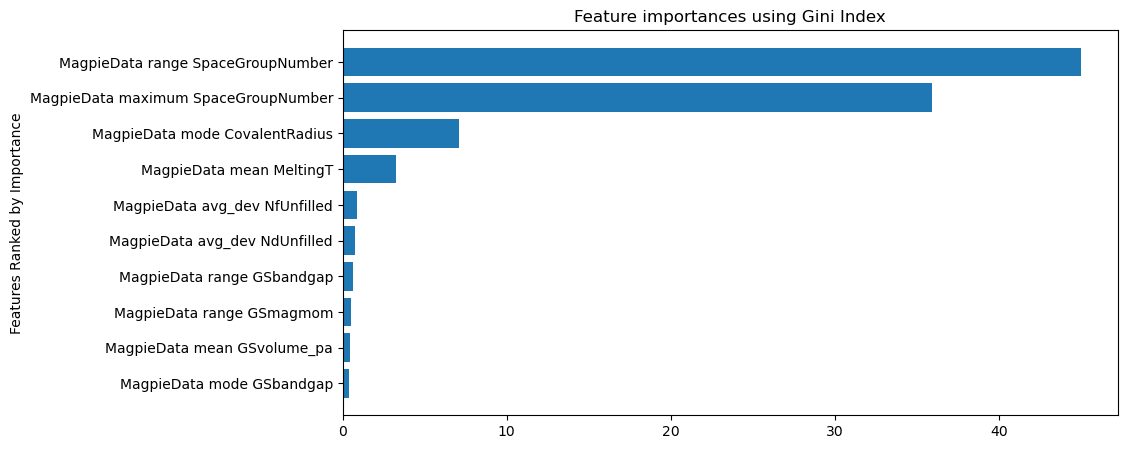

In [51]:
# below codes modified from PRA 9
importance = lasso.coef_ #using Gini importance implemented by Sklearn (Mean decrease in impurity)

# plot feature importance
sort = importance.argsort()[-10:]
plt.figure(figsize=(10, 5))
plt.barh(features.columns[sort], importance[sort])
plt.title("Feature importances using Gini Index")
plt.ylabel("Features Ranked by Importance")

- from the plot above, it can be seen that the Range and Max of SpaceGroupNumber are important.

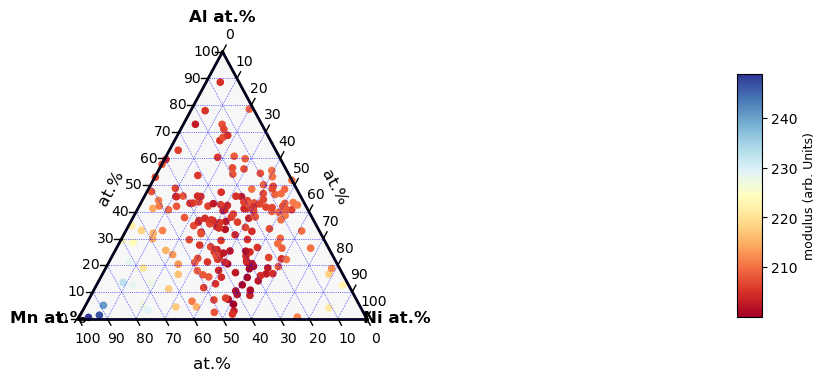

In [52]:
X_std = scaler.fit_transform(X)
lasso = Lasso(tol = 0.01, alpha = 0.018, random_state=0).fit(X_std, y)

y_pred = lasso.predict(X_std)

fig, axs = plt.subplots(1, 2, figsize = (9, 4))
df_plot_ternary(dff, y_pred, ax = axs[0], label = 'modulus (arb. Units)', cmap = plt.cm.RdYlBu)

Overall, the results looks very similar to the training data. The outlier identified earlier was also changed to a more reasonable value per prediction of the model

If another linear regression model is to be used such as Elastic Net, just change the imported linear model to ElasticNet. The rest are the same, so it will not be repeated here.

## PART II: ACTIVE LEARNING
### 1. read, clean data 

In [74]:
dff2 = pd.read_csv('dataset for Active Learning.csv')

# drop the rows with nan
dff2 = dff2.dropna()
dff2.head()

Ni at.%   Mn at.%   Al at.%  modulus (arb. Units)  \
0  0.234215  0.670439  0.095346               224.808   
1  0.421016  0.096702  0.482282               210.681   
2  0.229213  0.325603  0.445185               203.974   
3  0.469612  0.244500  0.285888               204.481   
4  0.081159  0.394314  0.524527               207.729   

   MagpieData minimum Number  MagpieData maximum Number  \
0                   0.482125                   1.596420   
1                  -0.153479                  -1.048070   
2                  -1.682480                  -0.913651   
3                   5.829040                   5.563230   
4                  -4.420820                  -4.625370   

   MagpieData range Number  MagpieData mean Number  MagpieData avg_dev Number  \
0                 0.007026                1.107490                  -1.406890   
1                -0.798757                0.240228                  -0.230692   
2                -1.748810               -0.025053                  -2.076410   
3                 4.575440                4.707300                   4.703800   
4                -6.232350               -4.583240                  -4.315980   

   MagpieData mode Number  ...  MagpieData range GSmagmom  \
0                1.172750  ...                  -0.973165   
1                0.941690  ...                   0.522952   
2               -0.983809  ...                  -3.490370   
3                6.373570  ...                   1.268280   
4               -3.960880  ...                  -2.775810   

   MagpieData mean GSmagmom  MagpieData avg_dev GSmagmom  \
0                 -0.760569                      1.54142   
1                 -0.000967                      1.41211   
2                 -1.754000                     -1.41139   
3                  0.872256                      2.39217   
4                 -0.310232                     -2.21879   

   MagpieData mode GSmagmom  MagpieData minimum SpaceGroupNumber  \
0                  1.770240                             0.406890   
1                  0.021429                            -0.150939   
2                  0.032722                            -1.536590   
3                  1.526820                            -0.229246   
4                 -2.731890                            -1.036630   

   MagpieData maximum SpaceGroupNumber  MagpieData range SpaceGroupNumber  \
0                             0.234215                           0.670439   
1                             0.421016                           0.096702   
2                             0.229213                           0.325603   
3                             0.469612                           0.244500   
4                             0.081159                           0.394314   

   MagpieData range Electronegativity  MagpieData mode CovalentRadius  \
0                            0.909059                        0.716545   
1                            0.617373                        0.647458   
2                            0.640706                        0.597281   
3                            0.751347                        0.601704   
4                            0.591836                        0.661210   

   MagpieData mean MeltingT  
0                  0.515752  
1                  1.297170  
2                  0.534121  
3                  0.224325  
4                 -0.299384  

[5 rows x 136 columns]

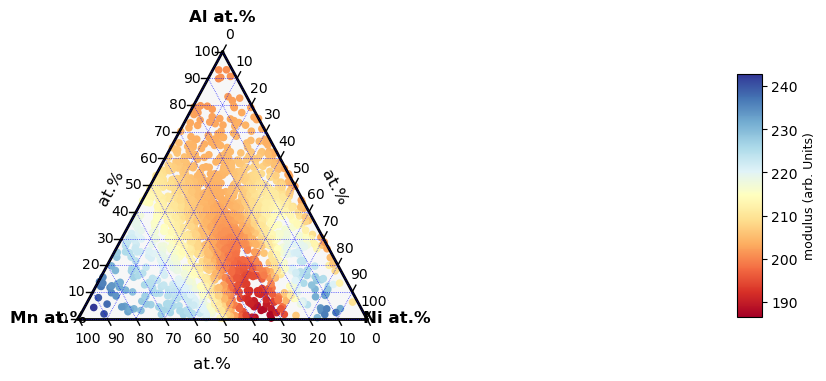

In [75]:
fig, axs = plt.subplots(1, 2, figsize = (9, 4))
df_plot_ternary(dff2, dff2['modulus (arb. Units)'], ax = axs[0], label = 'modulus (arb. Units)', cmap = plt.cm.RdYlBu)

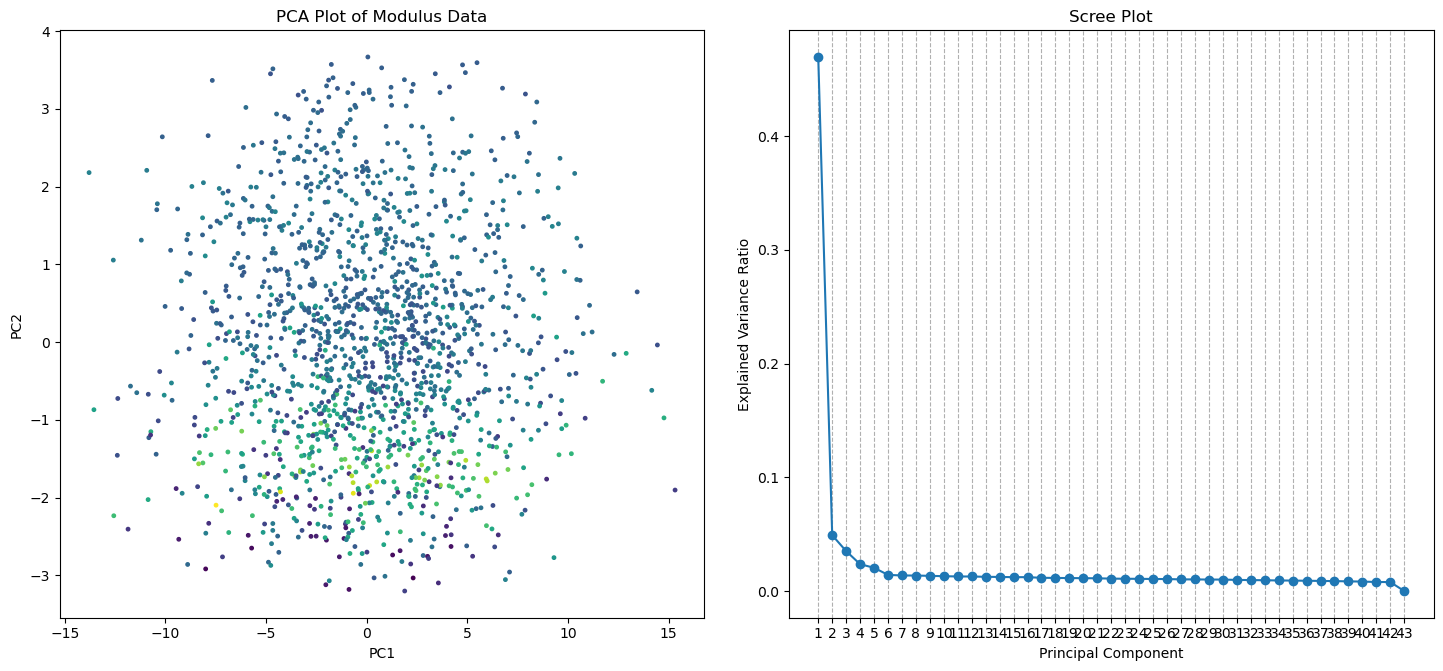

In [154]:
# slice dff2 into features2 so that features2 has the same columns as the features dataframe
features2 = dff2.loc[:, features.columns]
X = features2.to_numpy()
y = dff2['modulus (arb. Units)'].to_numpy()

# from features, define the ground truth
ground_truth = pd.concat([features2, dff2['modulus (arb. Units)']], axis=1)

# from /features, define prediction grid
X_pred_grid = features2.values

scaler = StandardScaler().fit(X_pred_grid)
X_pred_grid_std = scaler.transform(X_pred_grid)

# used for stopping criteria: y_opt
y_opt = ground_truth.iloc[:, -1].values.max()

# take a look at the prediction grid in principle component space
pca_plot(X_pred_grid_std, n_comp = 5, color_label=y, title = 'PCA Plot of Modulus Data', return_scree=True, alpha = 1);

- Define a versatile acquisition function

In [112]:
# Define generalacquisition function (can be exploit/random/explore)
def acq_new(X, y, y_std, mask, n_observ = 1, n_std = 2, top = 1, privilege = 10):
    '''
    This function first ranks the points in the prediction grid based on mean plus a *n_std* number of standard deviation, take the top *top* rows, and randomly select the rest with weighted possibility.
    input:
    X: loction of predicted points
    y: corresponding predicted y values
    y_std: corresponding predicted y_std values
    mask: ndarray with same length as X, indicating where samples have been taken out
    
    parameters: for tuning, incl:
    1. n_observ: the number of points to be observed next,
    2. n_std: (0 ~ 3) balances exploitation vs. exploration. Default is the LCB criteria: mean - 2*std. Zero value -> exploitation, very large value -> exploration
    3. top: (0 ~ 5 ususally) the top seeds that will be automatically from the top-ranked points. Default 1 is equivalent to sampling 1 point from the top-ranked points.
    4. privilege: (0 ~ 1000) the higher the privilege, the more likely the top-ranked points will be sampled. Default 10 is give high ranked reasonable privilege to be sampled. 0 means perfect random sampling
    
    output:
    X_next: the proposed new locations to observe'''

    ### 0. initialize the df to store the input
    # make a input_df to store X. This way avoid incessent indexing across input variables
    input_df = pd.DataFrame(X)

    input_df['y_pred'], input_df['y_std'] = y, y_std
    # make a new column to store the upper confidence bound of the confidence interval
    input_df['UCB'] = input_df['y_pred'] + n_std * input_df['y_std']
    input_df = input_df[~mask]

    length = len(input_df)

    ### 1. select top performers (by UCB)
    # sort the df by UCB, and return the the ones with higest UCB
    sorted_index = input_df.sort_values('UCB', ascending=False).index.to_numpy()
    if top != 0:
        top_index = sorted_index[:top]
    else:
        top_index = []
    bottom_index = sorted_index[top:]

    if n_observ > top:
        ### 2. select the lucky losers (by weighted random sampling)
        n_lucky = int(n_observ - top) # determine the number of lucky losers
        weights = np.power(np.linspace(1, 0, length-top), privilege) 
        weights = weights/weights.sum()  
        
        lucky_indices = np.random.choice(bottom_index, 
                                size=n_lucky, replace=False, p=weights)
        
        if top != 0:
            index = np.concatenate((top_index, lucky_indices))
        else:
            index = lucky_indices

    else:
        index = top_index
    
    return index

In [87]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

### 2. Three acquisition policies will be tried out below
- each acquisition policy will take place in one cell only.
- the cells are mostly the same, except that:
    - for random, 10 observations are made at each iteration. This speeds up the process
    - variable names to output the file and images (else the variable/file will be overwritten)
    - the settings to the acquisition function (will be explained in markdown)
### 2a. Try Random
the acquisition function has been adjusted to simulate random selection:
- **n_observ = 10** 10 points will be observed at each iteration
- **top = 0**, so zero top-ranked prediction point will be selected, and 
- **privilege = 0** so regardless of rank, each row has equal likelihood of being sampled, regardless of where the row ranks

In [133]:
kernel1 = RBF(length_scale=1e-6, length_scale_bounds=(1e-6, 1e-2))
kernel2 = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))

kernel = 0.6*kernel1 + 0.4*kernel2
GPR = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10, random_state=0, normalize_y=True)

error_list3_rand = []

# run random 3 times
for trial in tqdm(range(3)):
    # 1. select a small subset of data as initial training point
    train_df = ground_truth.sample(n = 10, random_state = trial, replace=False)
    # 1.1 also initialize the list of all observed indices, currently only five
    indices = train_df.index.to_list()

    X = train_df.iloc[:, :-1].values
    y = train_df.iloc[:, -1].values

    tot_observ = []
    error = []
    opt_lst = []

    mask = np.zeros((X_pred_grid.shape[0],), dtype=bool) # store the index of the observed points
    mask[indices] = True
    # loop: while not all data has been used to train
    for i in tqdm(range(len(ground_truth)-5)):

        # 1. fit the model
        X_std = scaler.transform(X)
        GPR.fit(X_std, y)

        # 3. predict the y values for the prediction grid
        y_pred_mean, y_pred_std = GPR.predict(X_pred_grid_std, return_std=True)

        if trial == 0:
            fig, axs = plt.subplots(1, 2, figsize = (9, 4));
            fig.suptitle(f'random iter.{i}.png', fontsize = 16);
            df_plot_ternary(dff2, y_pred_mean, ax = axs[0], label = 'modulus (arb. Units)', cmap = plt.cm.RdYlBu);
            fig.savefig(f'random iter.{i}.png')

        # 3.1 performance notes: calculate the RMSE between the predicted y and the ground truth y
        mse = mean_squared_error(y_pred_mean, ground_truth.iloc[:, -1].values)

        # 4. find the index of the next point to observe
        index = acq_new(X_pred_grid, y_pred_mean, y_pred_std, mask, n_observ = 10, n_std = 0, privilege = 0, top = 0) 
        
        # 4.1 create a boolean mask, to be used in the next loop (to avoid duplicate observations)
        mask[index] = True

        # 5. observe the X, y value of the next point
        X_next = X_pred_grid[index, :]
        # OBSERVE
        y_next = ground_truth.iloc[index, -1].values

        # NOTE here we record the error
        tot_observ.append(len(y))
        error.append(mse)
        opt_lst.append(np.max(y))
        
        # 6. append to training data
        X = np.append(X, X_next, axis=0); y = np.append(y, y_next, axis=0)

        # extra: break if there is a y in y that is below 190
        if np.max(y) == y_opt:
            break

    # record the error curve in this trial
    # arrange tot_observ, error, opt_lst into a 3-column array
    error_list3_rand.append(np.array([tot_observ, error, opt_lst]))
    

# save the error list
with open('error_list3_rand.pkl', 'wb') as f:
    pickle.dump(error_list3_rand, f)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warni

### 2b. Try Exploitation
the acquisition function has been adjusted to simulate standard exploitation:
- **n_observ = 1**
- **n_std = 0** the basis to rank the row is mean+0*std, which means the values with the highest predicted mean will be ranked first.
- **top = 1**, so of the 1 points to observ, 1 of them is the top-ranked points

  0%|          | 0/3 [00:00<?, ?it/s]/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warni

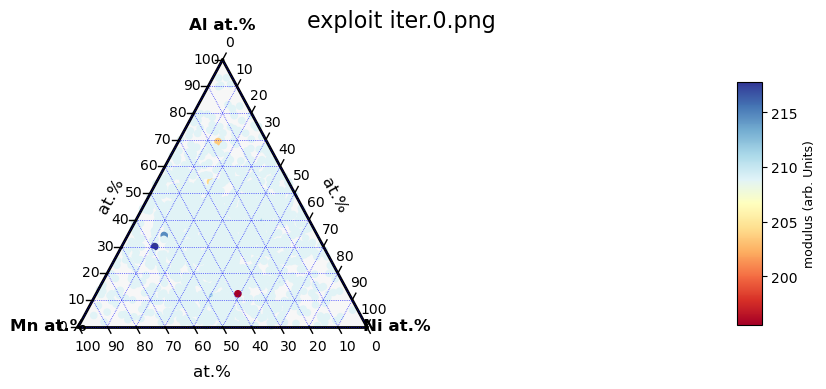

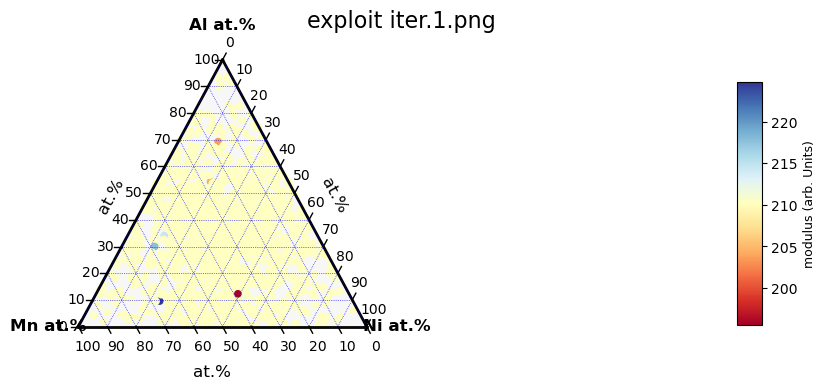

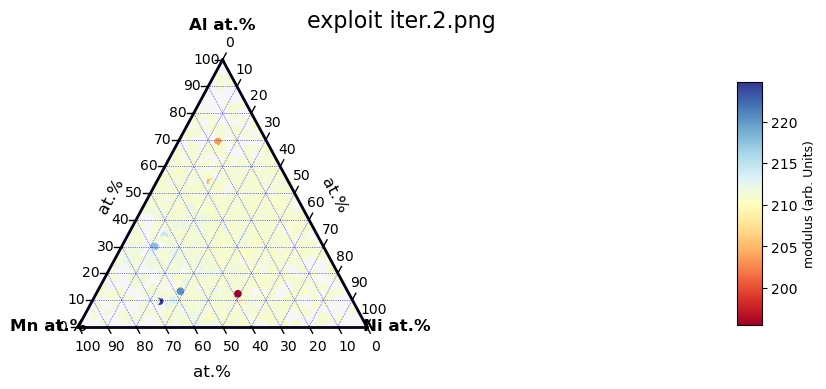

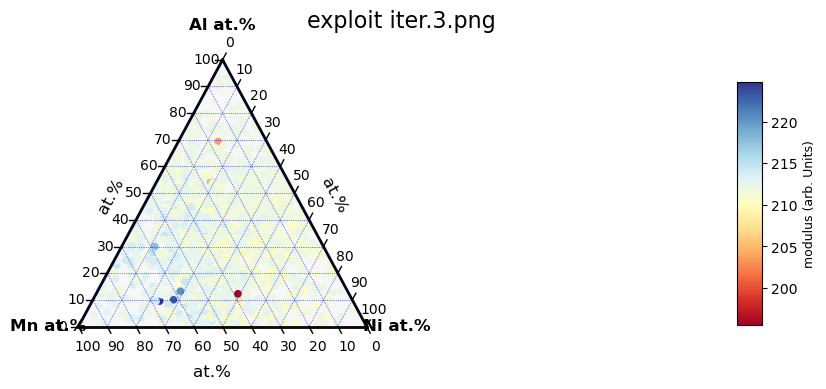

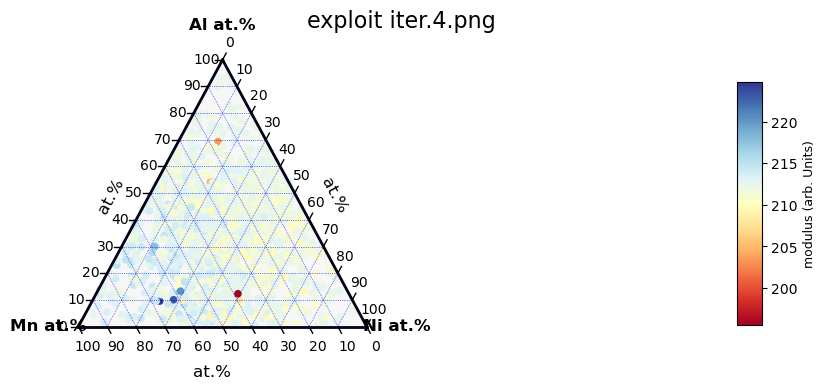

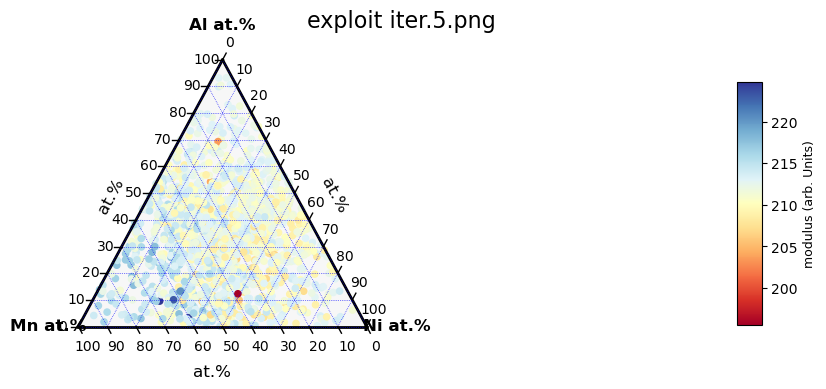

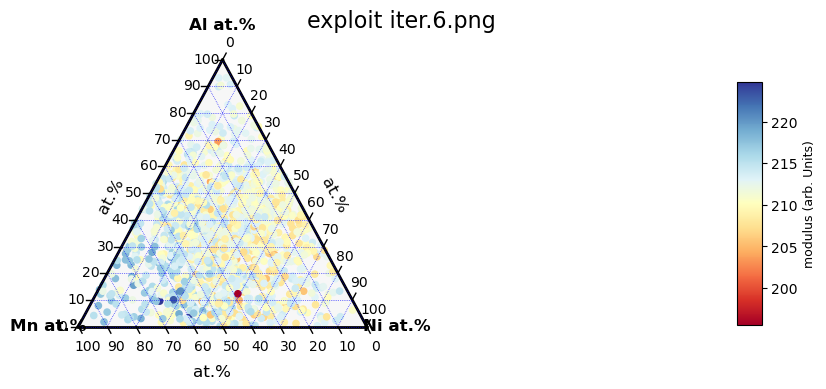

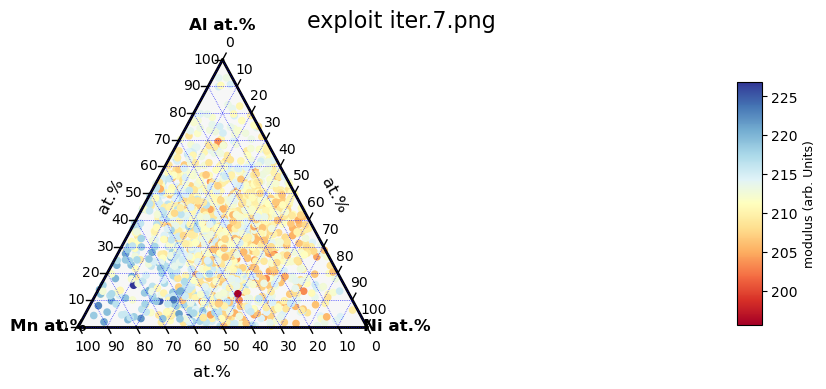

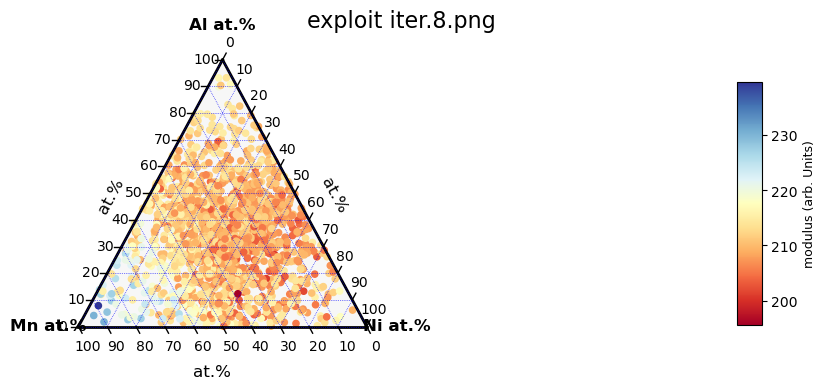

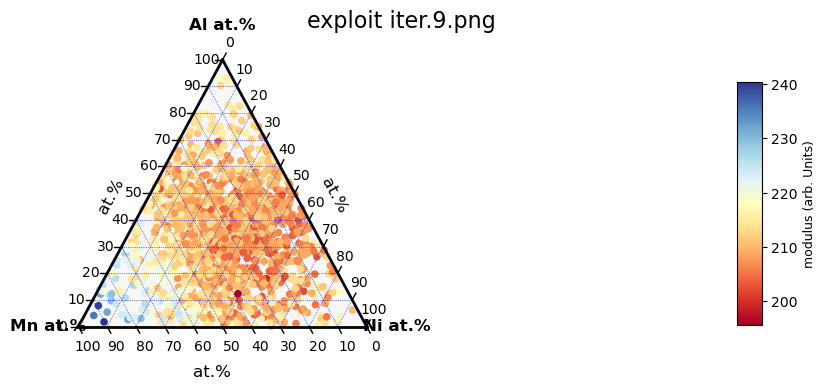

In [135]:
kernel1 = RBF(length_scale=1e-6, length_scale_bounds=(1e-6, 1e-2))
kernel2 = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))

kernel = 0.6*kernel1 + 0.4*kernel2
GPR = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10, random_state=0, normalize_y=True)

error_list3_exploit = []

# run random 3 times
for trial in tqdm(range(3)):
    # 1. select a small subset of data as initial training point
    train_df = ground_truth.sample(n = 10, random_state = trial, replace=False)
    # 1.1 also initialize the list of all observed indices, currently only five
    indices = train_df.index.to_list()

    X = train_df.iloc[:, :-1].values
    y = train_df.iloc[:, -1].values

    tot_observ = []
    error = []
    opt_lst = []

    mask = np.zeros((X_pred_grid.shape[0],), dtype=bool) # store the index of the observed points
    mask[indices] = True
    # loop: while not all data has been used to train
    for i in tqdm(range(len(ground_truth)-5)):

        # 1. fit the model
        X_std = scaler.transform(X)
        GPR.fit(X_std, y)

        # 3. predict the y values for the prediction grid
        y_pred_mean, y_pred_std = GPR.predict(X_pred_grid_std, return_std=True)

        if trial == 0:
            fig, axs = plt.subplots(1, 2, figsize = (9, 4));
            fig.suptitle(f'exploit iter.{i}.png', fontsize = 16);
            df_plot_ternary(dff2, y_pred_mean, ax = axs[0], label = 'modulus (arb. Units)', cmap = plt.cm.RdYlBu);
            fig.savefig(f'exploit iter.{i}.png')

        # 3.1 performance notes: calculate the RMSE between the predicted y and the ground truth y
        mse = mean_squared_error(y_pred_mean, ground_truth.iloc[:, -1].values)

        # 4. find the index of the next point to observe
        index = acq_new(X_pred_grid, y_pred_mean, y_pred_std, mask, n_observ = 1, n_std = 0, privilege = 0, top = 1) 
        
        # 4.1 create a boolean mask, to be used in the next loop (to avoid duplicate observations)
        mask[index] = True

        # 5. observe the X, y value of the next point
        X_next = X_pred_grid[index, :]
        # OBSERVE
        y_next = ground_truth.iloc[index, -1].values

        # NOTE here we record the error
        tot_observ.append(len(y))
        error.append(mse)
        opt_lst.append(np.max(y))
        
        # 6. append to training data
        X = np.append(X, X_next, axis=0); y = np.append(y, y_next, axis=0)

        # extra: break if there is a y in y that is below 190
        if np.max(y) == y_opt:
            break

    # record the error curve in this trial
    # arrange tot_observ, error, opt_lst into a 3-column array
    error_list3_exploit.append(np.array([tot_observ, error, opt_lst]))
    

# save the error list
with open('error_list3_exploit.pkl', 'wb') as f:
    pickle.dump(error_list3_exploit, f)

### 2c. Try my own Acquisition Policy

- With the goal of finding the max Uses Upper Confidence bound to select next observation point
- **n_observ = 1**
- **n_std = 2** the basis to rank the row is mean+0*std, which means the values with the highest predicted mean will be ranked first.
- **top = 0**, so the top 0 number of points will be selected
- **privilege = 100** so higher-ranked points are much more likely to be selected

  0%|          | 0/3 [00:00<?, ?it/s]/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warni

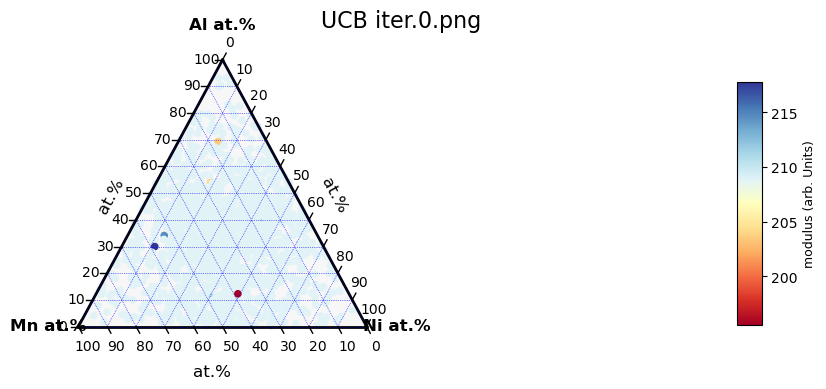

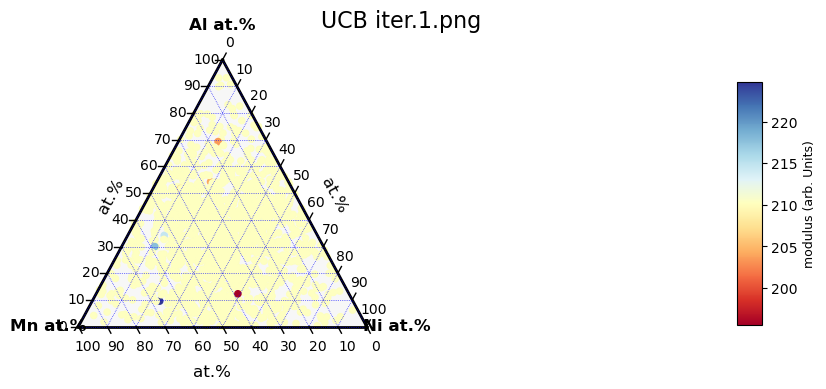

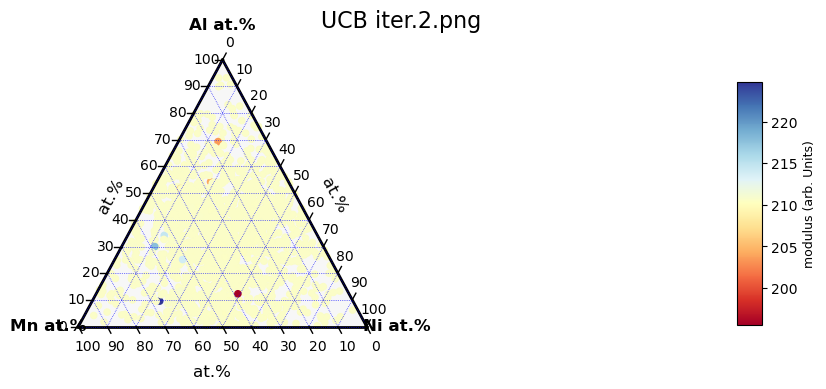

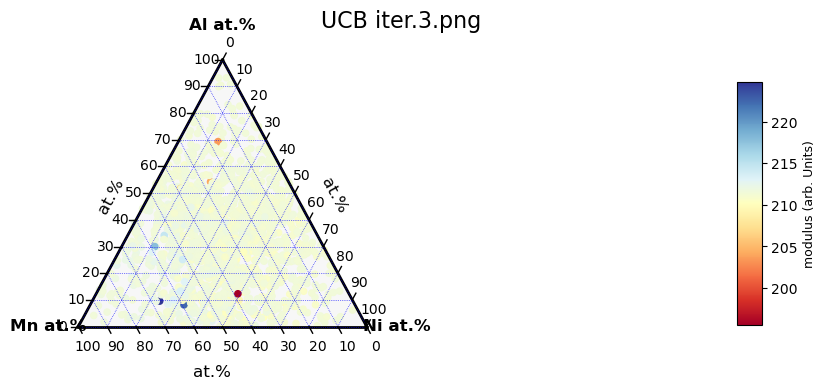

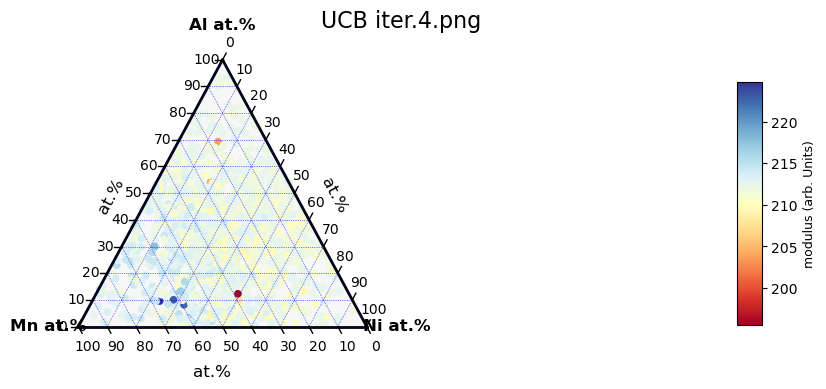

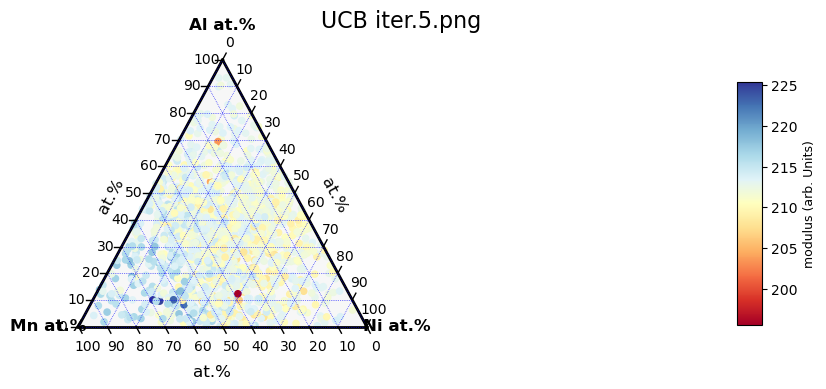

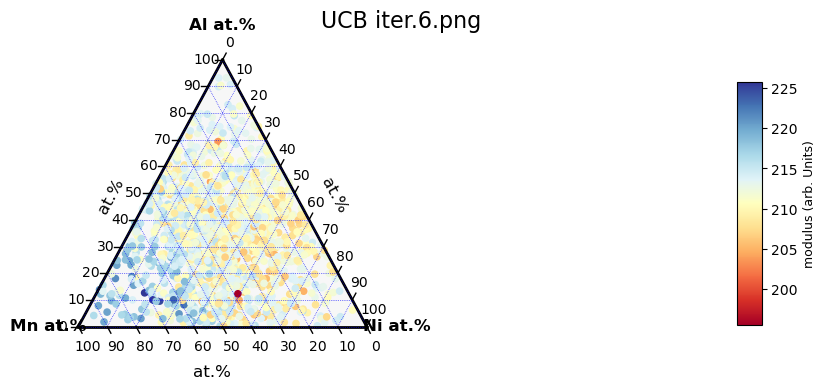

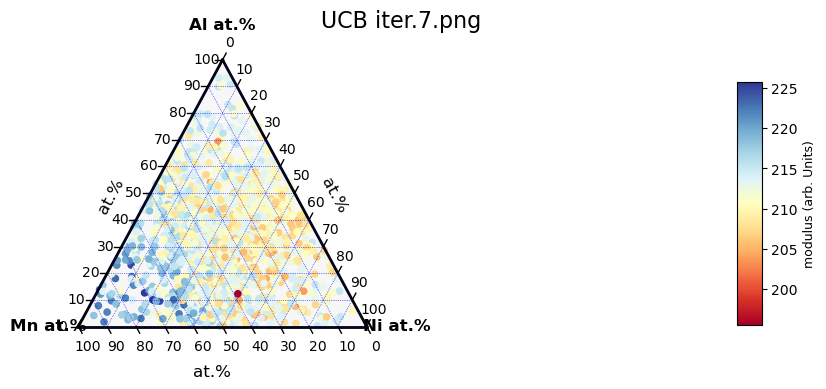

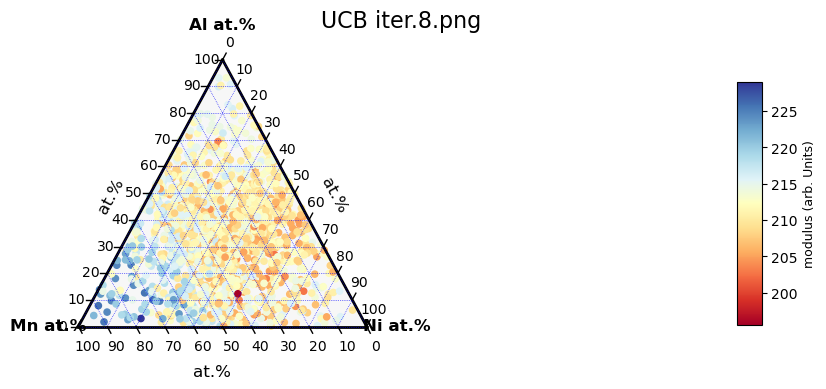

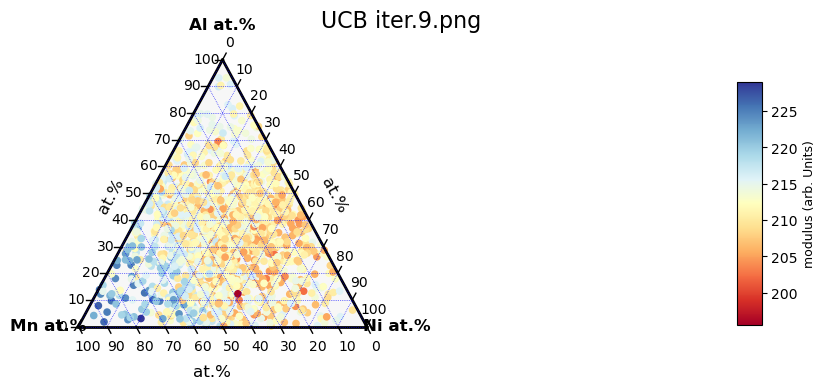

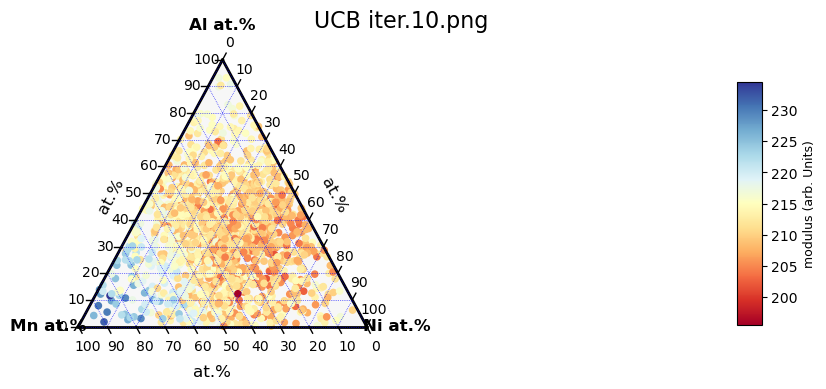

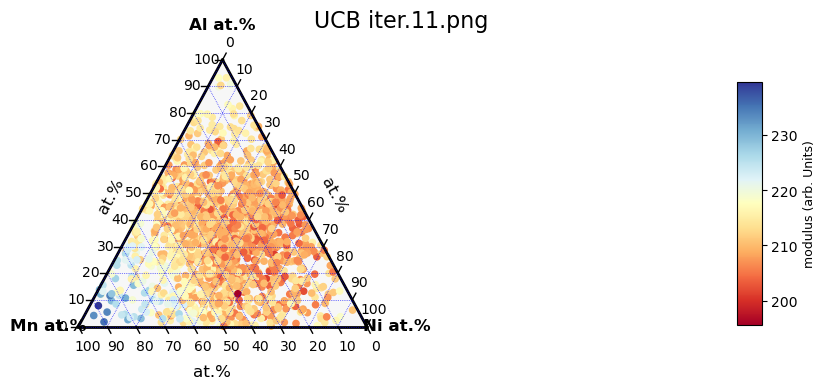

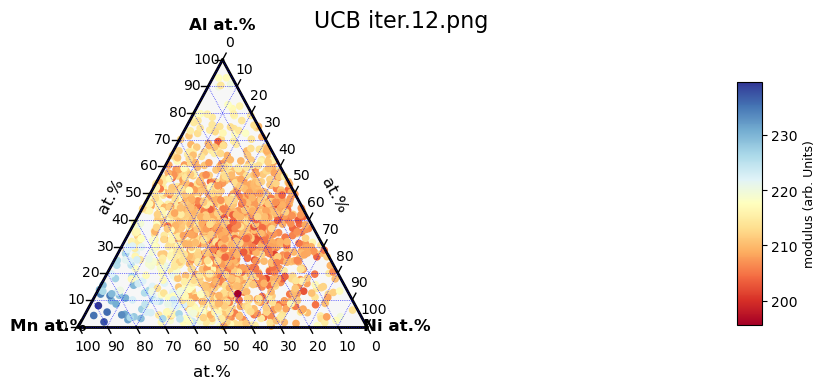

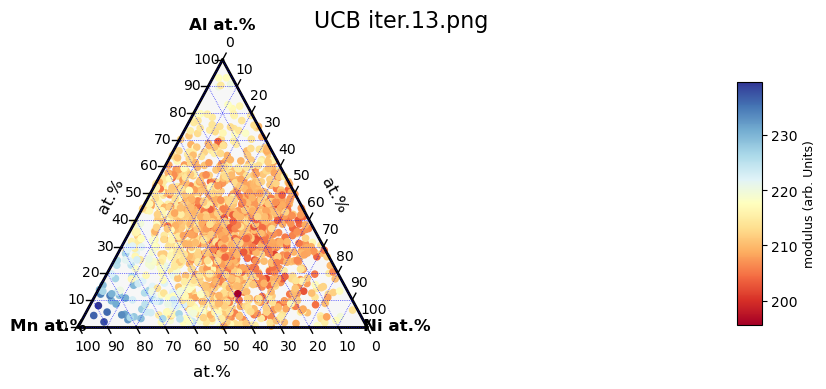

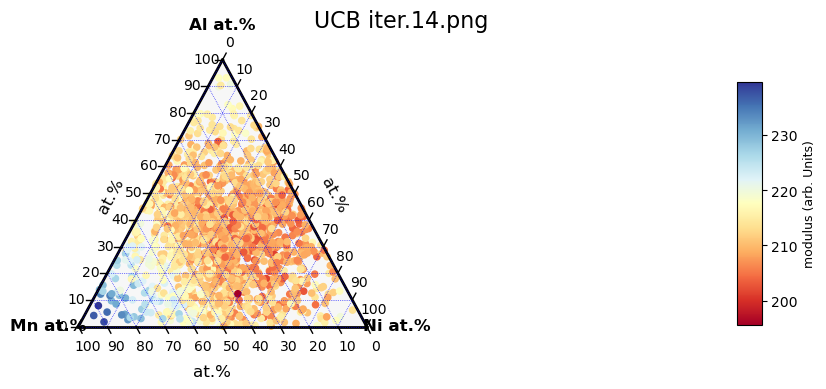

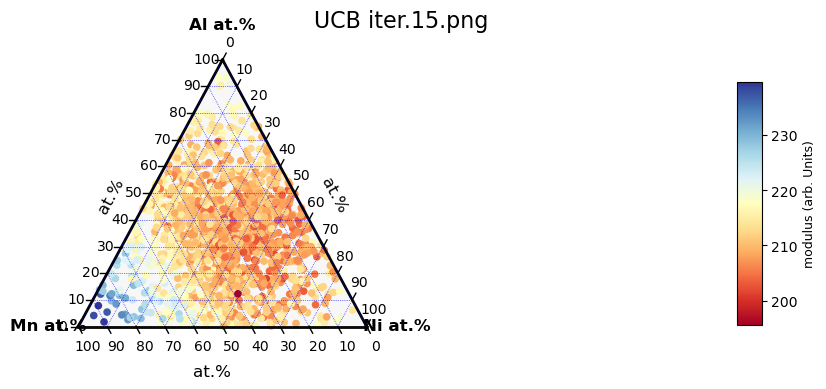

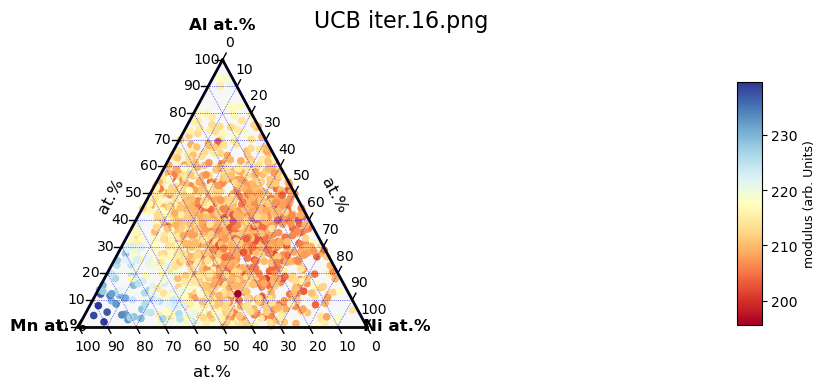

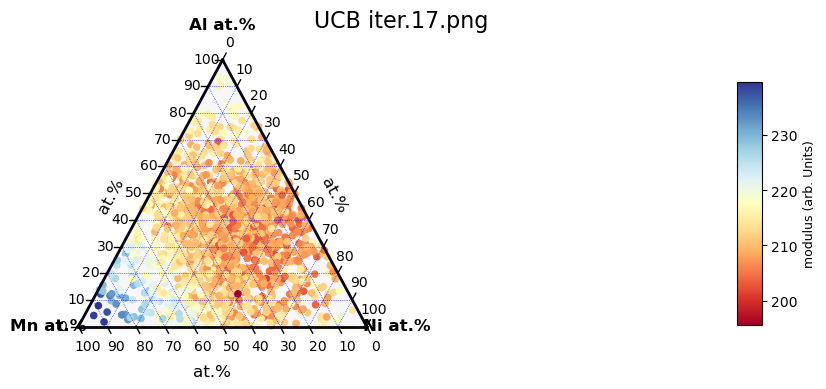

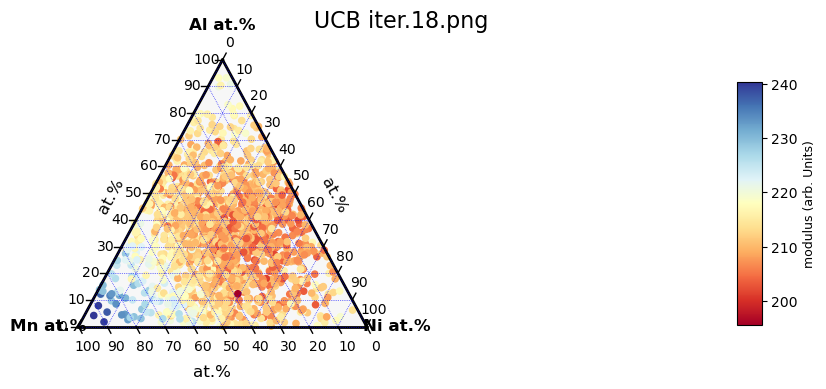

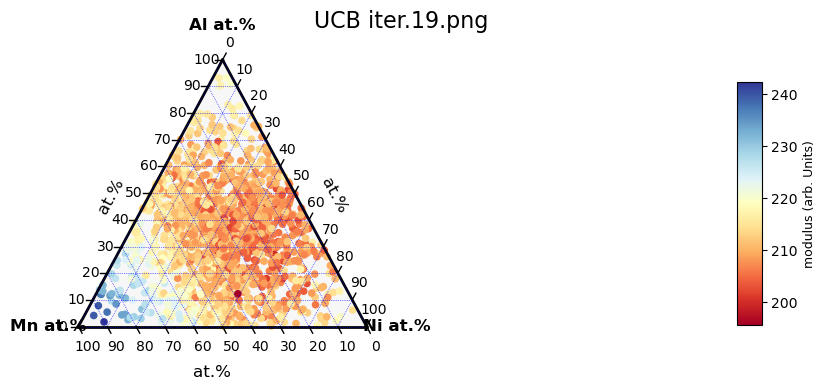

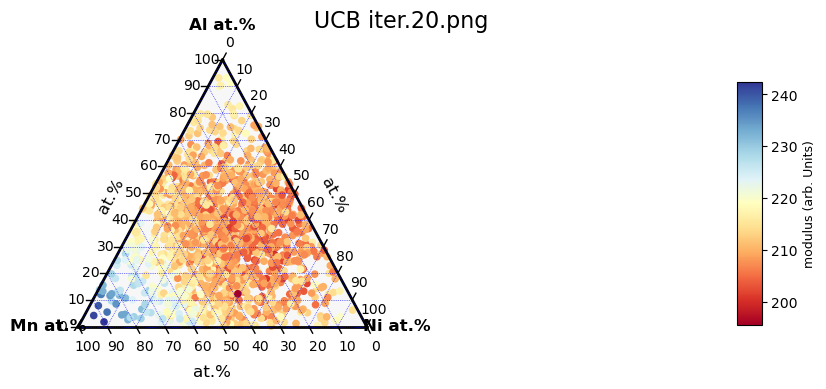

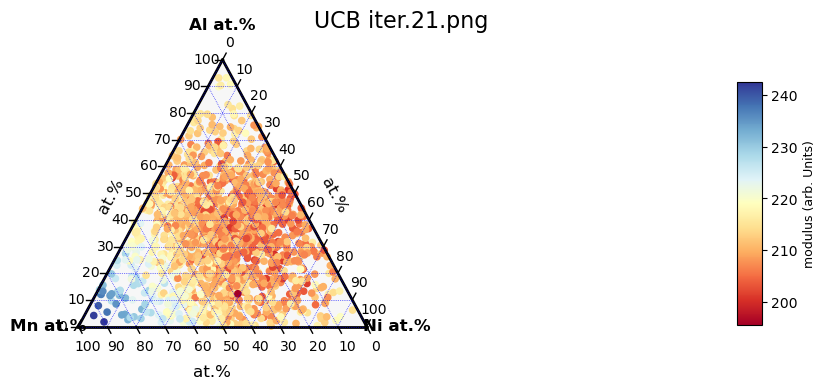

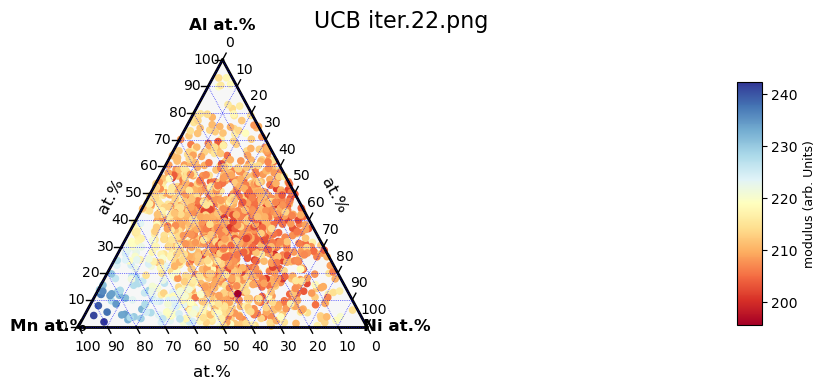

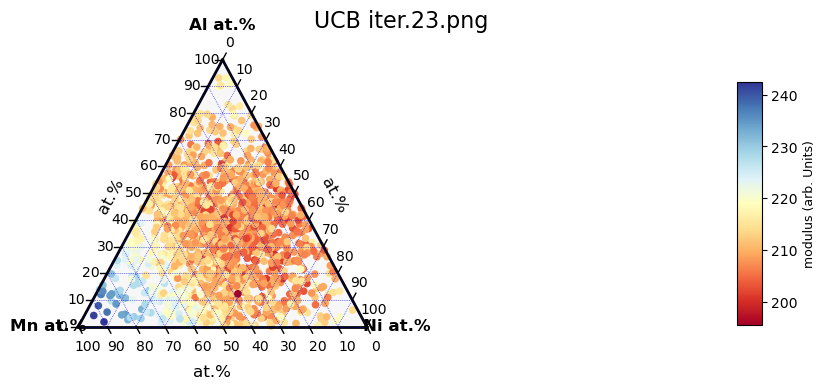

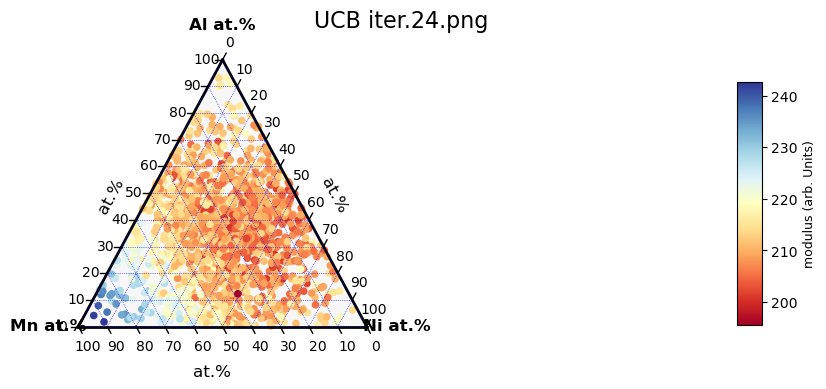

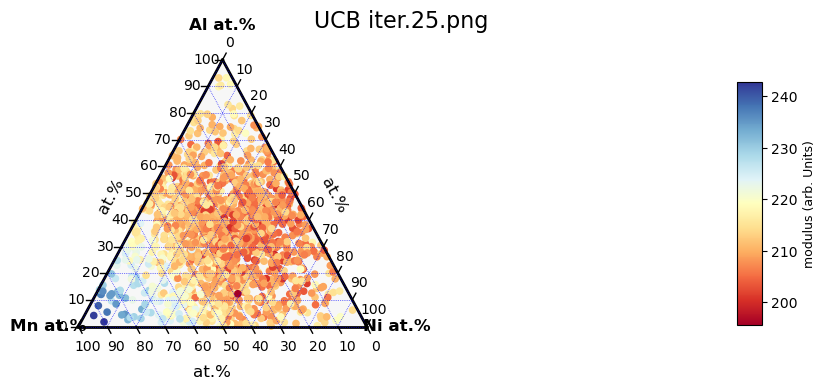

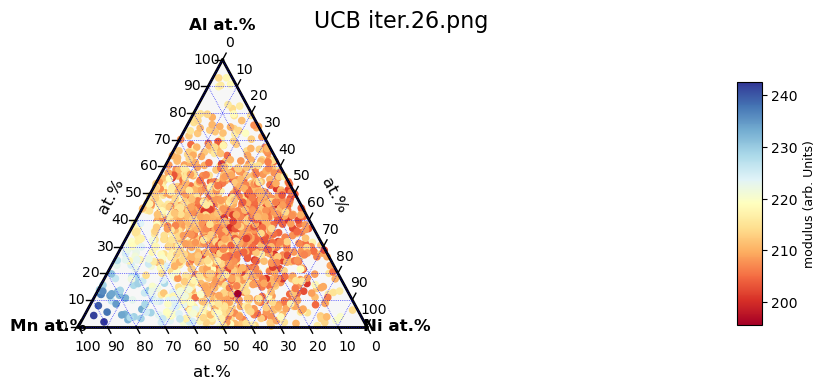

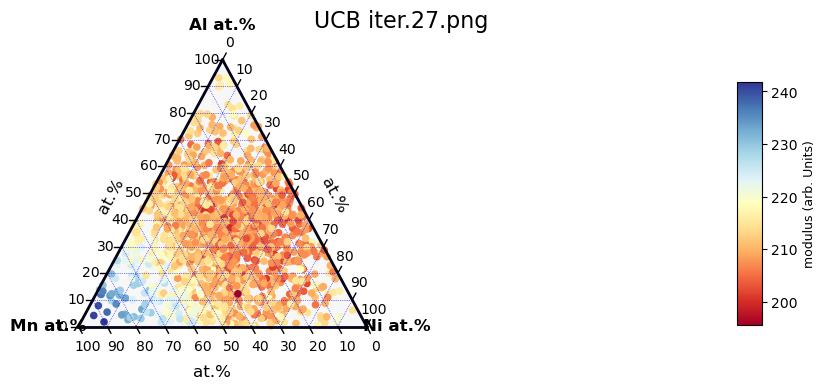

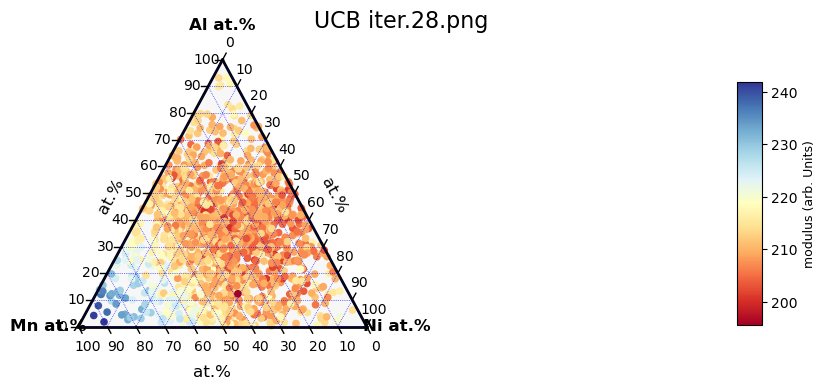

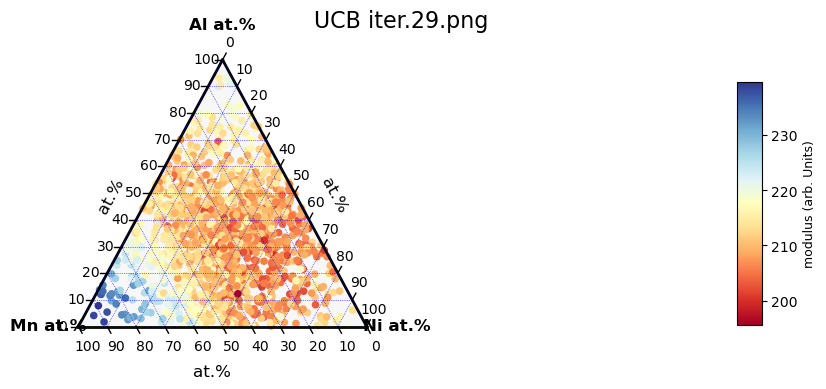

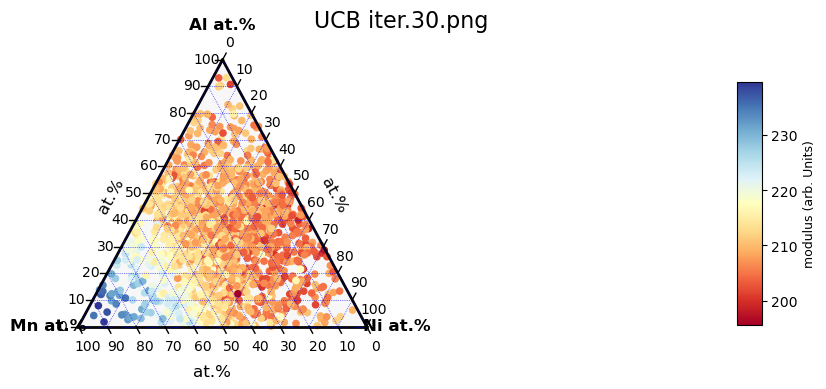

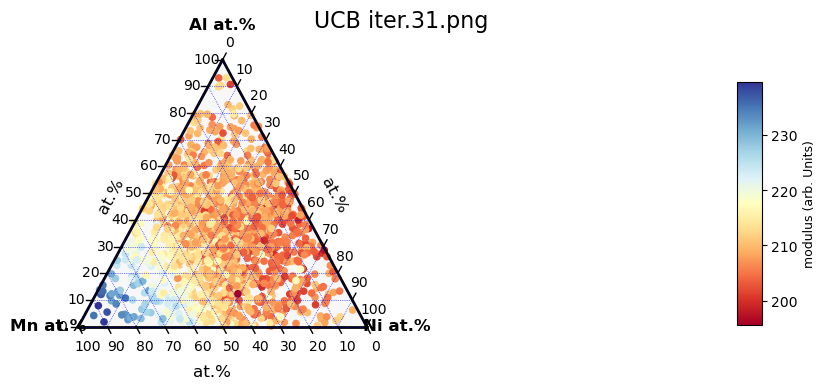

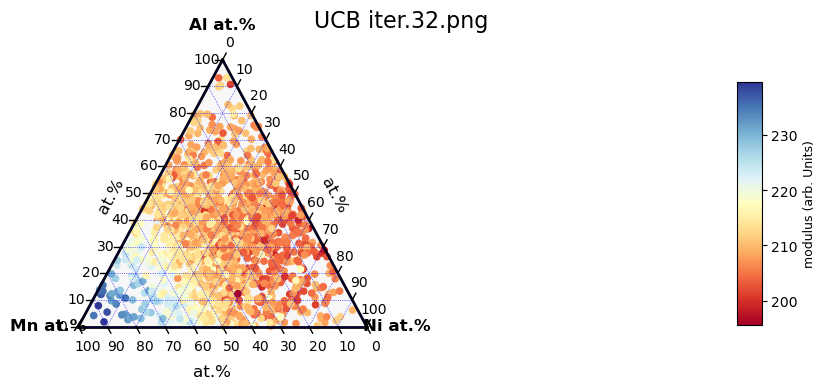

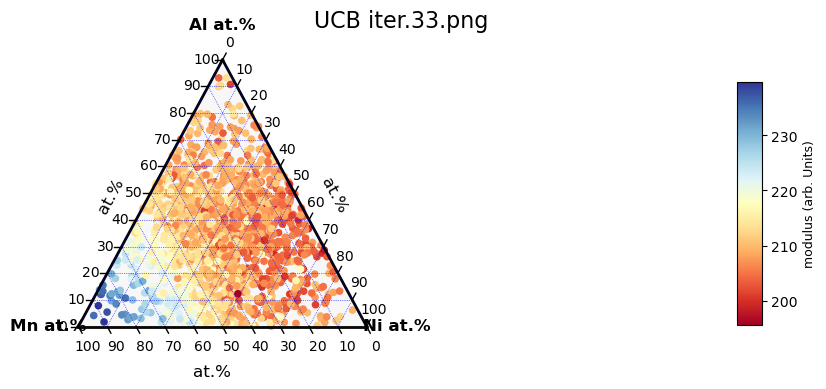

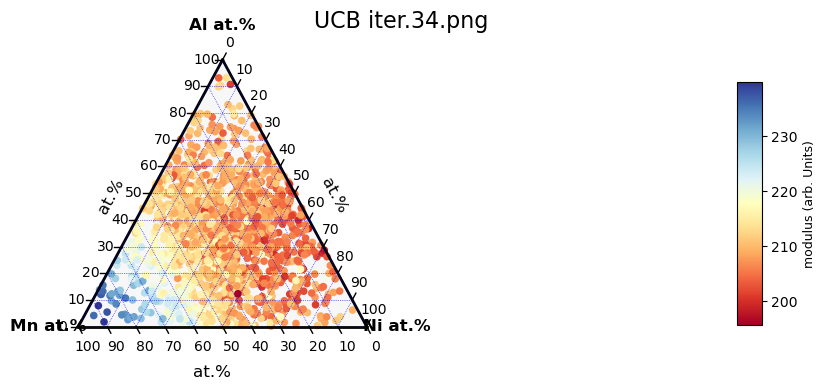

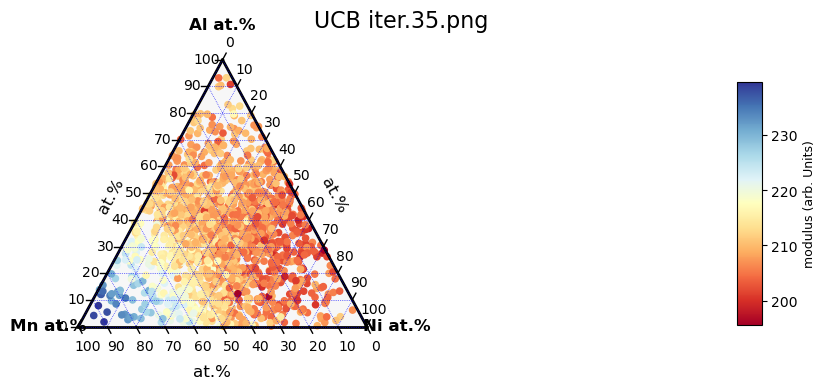

In [136]:
kernel1 = RBF(length_scale=1e-6, length_scale_bounds=(1e-6, 1e-2))
kernel2 = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))

kernel = 0.6*kernel1 + 0.4*kernel2
GPR = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10, random_state=0, normalize_y=True)

error_list3_UCB = []

# run random 3 times
for trial in tqdm(range(3)):
    # 1. select a small subset of data as initial training point
    train_df = ground_truth.sample(n = 10, random_state = trial, replace=False)
    # 1.1 also initialize the list of all observed indices, currently only five
    indices = train_df.index.to_list()

    X = train_df.iloc[:, :-1].values
    y = train_df.iloc[:, -1].values

    tot_observ = []
    error = []
    opt_lst = []

    mask = np.zeros((X_pred_grid.shape[0],), dtype=bool) # store the index of the observed points
    mask[indices] = True
    # loop: while not all data has been used to train
    for i in tqdm(range(len(ground_truth)-5)):

        # 1. fit the model
        X_std = scaler.transform(X)
        GPR.fit(X_std, y)

        # 3. predict the y values for the prediction grid
        y_pred_mean, y_pred_std = GPR.predict(X_pred_grid_std, return_std=True)

        if trial == 0:
            fig, axs = plt.subplots(1, 2, figsize = (9, 4));
            fig.suptitle(f'UCB iter.{i}.png', fontsize = 16);
            df_plot_ternary(dff2, y_pred_mean, ax = axs[0], label = 'modulus (arb. Units)', cmap = plt.cm.RdYlBu);
            fig.savefig(f'UCB iter.{i}.png')

        # 3.1 performance notes: calculate the RMSE between the predicted y and the ground truth y
        mse = mean_squared_error(y_pred_mean, ground_truth.iloc[:, -1].values)

        # 4. find the index of the next point to observe
        index = acq_new(X_pred_grid, y_pred_mean, y_pred_std, mask, n_observ = 1, n_std = 2, privilege = 100, top = 0) 
        
        # 4.1 create a boolean mask, to be used in the next loop (to avoid duplicate observations)
        mask[index] = True

        # 5. observe the X, y value of the next point
        X_next = X_pred_grid[index, :]
        # OBSERVE
        y_next = ground_truth.iloc[index, -1].values

        # NOTE here we record the error
        tot_observ.append(len(y))
        error.append(mse)
        opt_lst.append(np.max(y))
        
        # 6. append to training data
        X = np.append(X, X_next, axis=0); y = np.append(y, y_next, axis=0)

        # extra: break if there is a y in y that is below 190
        if np.max(y) == y_opt:
            break

    # record the error curve in this trial
    # arrange tot_observ, error, opt_lst into a 3-column array
    error_list3_UCB.append(np.array([tot_observ, error, opt_lst]))
    

# save the error list
with open('error_list3_UCB.pkl', 'wb') as f:
    pickle.dump(error_list3_UCB, f)

### 3. Plotting the learning curves

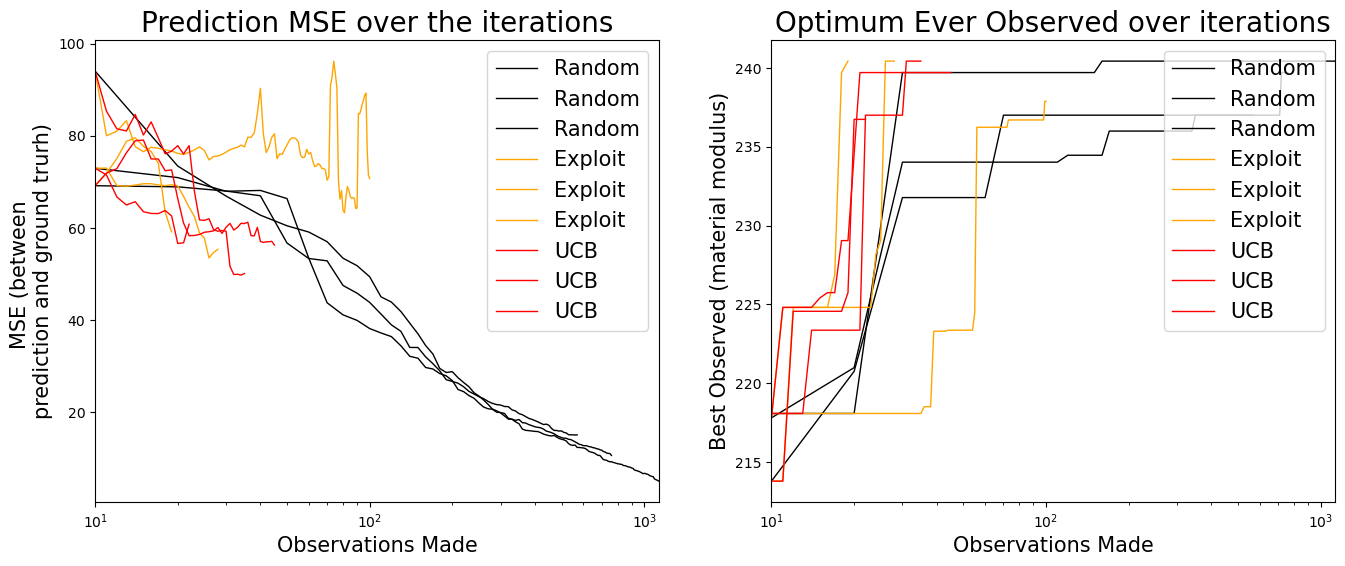

In [152]:
# plot the results
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
pickles = ['error_list3_rand.pkl', 'error_list3_exploit.pkl', 'error_list3_UCB.pkl']
policies = ['Random', 'Exploit', 'UCB']
colors = ['k', 'orange', 'r']

for j in range(3):
    with open (pickles[j], 'rb') as f:
        method = pickle.load(f)

    for i in range(len(error_list3_exploit)): # for each trial
        trial = method[i]
        axs[0].plot(trial[0, :], trial[1, :], color= colors[j], linewidth = 1, alpha=1, label = policies[j])
        axs[1].plot(trial[0, :], trial[2, :], color= colors[j], linewidth = 1, alpha=1, label = policies[j])

axs[0].set_title('Prediction MSE over the iterations', fontsize=20)
axs[0].set_xlabel('Observations Made', fontsize=15)
axs[0].set_ylabel('MSE (between \nprediction and ground trurh)', fontsize=15)
axs[0].legend(loc='upper right', fontsize=15)
axs[0].set_xscale('log')
axs[0].margins(x=0)

axs[1].set_title('Optimum Ever Observed over iterations', fontsize=20)
axs[1].set_xlabel('Observations Made', fontsize=15)
axs[1].set_ylabel('Best Observed (material modulus)', fontsize=15)
axs[1].legend(loc='upper right', fontsize=15)
axs[1].set_xscale('log')
axs[1].margins(x=0)

## Summary

This course does closed some knowledge gap I had before. During my internship at a thermoplastic fabric plant, there is a lot of production data produced daily. They makes large sheets of thermoplastics fabrics, where heating temperature is a key factor of success. But during summer, I observed that the fabrics have lower permeability (as if it was processed under higher temperature), and during winter the opposite happens. I thought it was an interesting thing to do, that if we still cannot build a air-conditioned facility, it is worthwhile to explore how much will ambient temperature affects the fabric , and ideally with active learning, we can backcalculate, given the the temperature of the day, how much heating do we _actually_ need to apply to achieve the intended heat setting effect.

Overall, this course is very inspiring. Whether I will utilize the skills depends on the type of job I undertake, but the most important things I take away from the course are not technical. I start to understand that behind seemingly complex cognitive tasks (e.g. clustering) are just simple maths, and much of the advancement were inspired by analyzing the way humans think. This course was also especially valueble and refreshing - I am learning or even hearing a lot of things for the first time.